<a href="https://colab.research.google.com/github/SiraajR/ML-in-Cybr_Security/blob/main/CAPTCHA_20260121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EEP 467 Homework 2: Breaking CAPTCHAs End-to-End

In lab 2, we have successfully built a pipeline that automatically recognizes CAPTCHAs. So far, the recognition process requires manually identifying contours (and subsequently bounding boxes) around characters using expert rules, before performing classification on extracted character images. This inspires us for possible further improvement: can we use a single neural network to directly identify CAPTCHA characters from CAPTCHA image? In this homework, we will get rid of bounding box identification and build an end-to-end neural network model.

## Before You Start

1. You can discuss on Discord if you have questions and want to seek help; however, please try your best to **limit the scope of your question** and **avoid asking directly for answers**. You should also **avoid copy-pasting answers and code** from others.
2. You are allowed to use AI assistants for help. In this case, you should **acknowledge your use of AI assistant** by providing its **name as well as how it helps you** to obtain your answer. Again, you **should not copy-paste from the response** of the AI assistant.

## Pre-processing

First of all, make sure you have installed all dependencies needed for this homework. The list of depedencies is similar to lab 3, except that we will ditch OpenCV and `imutils`, and instead use PyTorch Vision (`torchvision`) for some of our preprocessing work:

In [1]:
%pip install matplotlib scikit-learn tqdm

# If using Anaconda / Miniconda, install PyTorch and PyTorch Vision with:
# %conda install conda-forge::pytorch-gpu conda-forge::torchvision # (CPU and GPU support)
# %conda install conda-forge::pytorch conda-forge::torchvision # (CPU-only support)

# If using Pip, install PyTorch and PyTorch Vision with:
%pip install torch torchvision
# When installing PyTorch with GPU support, refer to https://pytorch.org/get-started/locally/
# if your CUDA version differs from the default CUDA version of the current version PyTorch package.

Once you are ready, we will start with data pre-processing step where we load all CAPTCHA images into memory. There are a few utilities in `torchvision` which can help us do the job:

In [2]:
import os
import zipfile
import torch
from torchvision.datasets.folder import IMG_EXTENSIONS
from torchvision.io import ImageReadMode, decode_image

# CAPTCHA images directory
# Corrected path to the actual image directory after extraction
CAPTCHA_IMAGES_DIR = "captcha-images/captcha-images/captcha-images"
with zipfile.ZipFile("captcha-images.zip", "r") as zip_file:
    zip_file.extractall("captcha-images/captcha-images") # Extract to the parent directory

#

# CAPTCHA images
captcha_images = []
# CAPTCHA texts
captcha_texts = []

## [ TODO ]
# 1) Load all CAPTCHA images from `CAPTCHA_IMAGES_DIR` into `captcha_images`
#    (Hint: use `os.scandir` to iterate over directory entries and check file extensions with `IMG_EXTENSIONS`)
#    (Hint: use `torchvision.io.decode_image` to load images in grayscale mode)
#    (Note: your code should ignore non-image files)
images = os.scandir(CAPTCHA_IMAGES_DIR)
for image_entry in images:
  if image_entry.is_file() and image_entry.name.lower().endswith(tuple(ext.lower() for ext in IMG_EXTENSIONS)): # Ensure case-insensitive extension check
    full_image_path = os.path.join(CAPTCHA_IMAGES_DIR, image_entry.name)
    captcha_images.append(decode_image(full_image_path, mode=ImageReadMode.GRAY)) # Added full path and grayscale mode
    captcha_texts.append(image_entry.name.split('.')[0])
# print(captcha_images[0].shape) # Commented out for now to prevent error if list is empty, will be re-enabled after further steps
# 2) Stack all CAPTCHA images into a PyTorch tensor
captcha_images = torch.stack(captcha_images)
# 3) Load all CAPTCHA texts (filenames without extension) into `captcha_texts`
#    (Items in `captcha_images` and `captcha_texts` should match)
print(captcha_images.shape)

assert isinstance(captcha_images, torch.Tensor), "`captcha_images` must be a PyTorch tensor!"
assert captcha_images.ndim==4, "`captcha_images` should be a 4D tensor!"
assert captcha_images.shape[1:]==(1, 24, 72), "`captcha_images` should have shape (n_images, 1, h, w)!"

assert len(captcha_images)==len(captcha_texts), \
    "`captcha_images` should have the same number of elements as `captcha_texts`!"
assert all(isinstance(text, str) and len(text)==4 for text in captcha_texts), \
    "all `captcha_texts` should be strings with four letters!"


torch.Size([1136, 1, 24, 72])


Then, we split all CAPTCHA images and texts into training-validation and test sets:

In [3]:
from sklearn.model_selection import train_test_split

# Training-validation-test split seed
TVT_SPLIT_SEED = 31528476

# Split dataset into training and test sets
captcha_images_tv, captcha_images_test, captcha_texts_tv, captcha_texts_test = train_test_split(
    captcha_images, captcha_texts, test_size=0.2, random_state=TVT_SPLIT_SEED
)

Next, we encode each character in the CAPTCHA text as class indices:

In [5]:
from sklearn.preprocessing import LabelEncoder
import hw2_util

# Label encoder
le = LabelEncoder()

## [ TODO ]
# 1) Flatten training-validation CAPTCHA texts into list of characters
#    (Hint: `hw2_util.flatten` can help you with that)
flatten_text = list(hw2_util.flatten(captcha_texts_tv))
# 2) Fit and transform characters into class indices using `LabelEncoder`
texts_class_indices_tv = le.fit_transform(flatten_text)
# 3) Save number of classes (distinct characters) in `n_classes`
n_classes = len(le.classes_)
# 4) Convert class indices to PyTorch tensor and reshape as `texts_class_indices_tv`
#    (The shape of `texts_class_indices_tv` should be (n_images, 4))
texts_class_indices_tv = torch.tensor(texts_class_indices_tv).reshape(-1, 4)

assert isinstance(texts_class_indices_tv, torch.Tensor), "`texts_class_indices_tv` must be a PyTorch tensor!"
assert texts_class_indices_tv.ndim==2, "`texts_class_indices_tv` must have two dimensions!"
assert texts_class_indices_tv.shape==(len(captcha_texts_tv), 4), \
    "Shape of `texts_class_indices_tv` should be (n_images, 4)!"

Then, we further split training-validation set into two parts:

In [6]:
# Split training set further into training and validation sets
captcha_images_train, captcha_images_vali, texts_class_indices_train, texts_class_indices_vali = train_test_split(
    captcha_images_tv, texts_class_indices_tv, test_size=0.25, random_state=TVT_SPLIT_SEED
)

## Data Augmentation

The following step will be unique to this homework: we will perform **data augmentation** using PyTorch's [`transforms.Compose`](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.Compose.html) and [`transforms.RandomAffine`](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.RandomAffine.html). Here we will configure the `RandomAffine` transform to **apply the following random effects** to our CAPTCHAs:

* Random rotation (at most 5 degrees)
* Random horizontal and vertical shifting (at most 10%)
* Random shearing (at most 5 degrees)
* Random zooming in or out (at most 10%)

Besides, we will also **pre-process the image pixels** in the `RescaleInvertPixels` custom transform. Here we need to first **rescale the grayscale values** to $[0, 1]$ range and then **invert the grayscales**. We will chain the `RescaleInvertPixels` transform together with the `RandomAffine` transform using `Compose` to create a complete augmentation pipeline.

Below code will create such a transform pipeline, and preview its effects on a few sample CAPTCHAs:

Figure(2000x500)
Figure(2000x500)


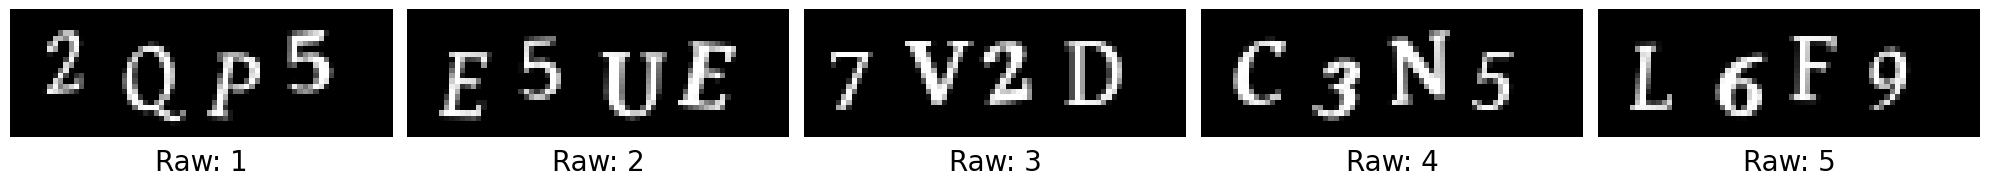

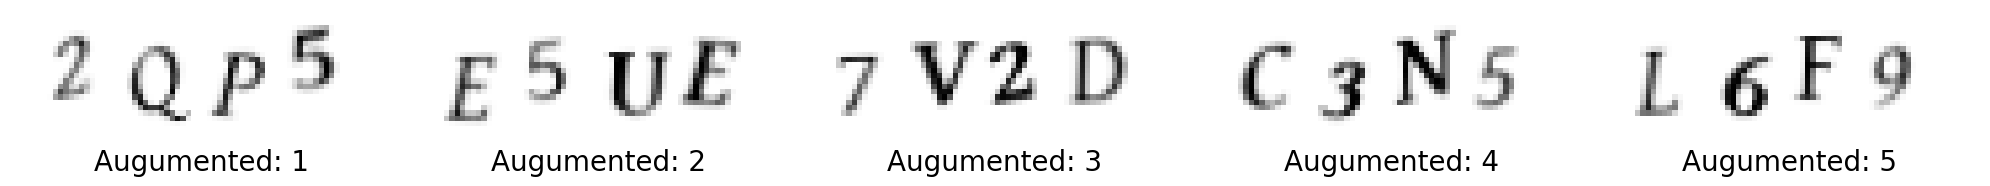

In [7]:
from torch import nn
from torchvision.transforms import Compose, InterpolationMode, RandomAffine

class RescaleInvertPixels(nn.Module):
    def forward(self, raw_image):
        ## [ TODO ]
        # 1) Rescale pixel grayscale values to [0, 1]
        change_raw_image = raw_image.float() / 255.
        # 2) Invert the grayscales of the image (darker becomes lighter, and vice versa)
        gray_raw_image = 1. - change_raw_image
        # 3) Return modified grayscales
        return gray_raw_image

## [ TODO ]
# Create a transform pipeline using `Compose` with:
# 1) `RescaleInvertPixels()` for preprocessing
# 2) `RandomAffine` with the following random effects:
#    - Rotation: at most 5 degrees
#    - Horizontal and vertical shift: at most 10%
#    - Zooming: at most 10% (scale between 0.9 and 1.1)
#    - Shearing: at most 5 degrees
#    - Use `InterpolationMode.BILINEAR` for interpolation
#
# Choose parameters such that CAPTCHAs are moderately distorted but still recognizable.
captcha_transform = Compose([
    RescaleInvertPixels(),
    RandomAffine(
        degrees=5,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
        shear=5,
        interpolation=InterpolationMode.BILINEAR
    )
])

# Select a few images for preview
preview_orig = captcha_images_train[:5]
# Generate a few transformed CAPTCHA images for preview
preview_trans = captcha_transform(preview_orig)

# Preview original and transformed CAPTCHAs
hw2_util.print_images(
    preview_orig.squeeze(-3),
    texts=[f"Raw: {i+1}" for i in range(5)]
)
hw2_util.print_images(
    preview_trans.squeeze(-3),
    texts=[f"Augumented: {i+1}" for i in range(5)]
)


Apart from the inversion of grayscale, you should be able to observe slight differences between original and transformed images. These transformed CAPTCHAs should still be easily recognizable, though.

## Training

From now on, we will shift our focus to the end-to-end neural network model. We assume our neural network model takes a bunch of CAPTCHA images (known as a batch) as input and outputs logits for each of the four character positions. In other words, if we have `n_classes` distinct characters in all CAPTCHAs, the output of our model would be a PyTorch tensor of shape `(batch_size, 4, n_classes)`. From each position's logits, we choose the character with the highest logit value (using the `argmax` operator), and we define a correct prediction as the one where all four characters are correctly predicted.

Our first task is to implement custom loss and accuracy functions for our task, since PyTorch's built-in functions expect different output formats. Both `pred_logits` (Raw model outputs) and `actual_class_indices` (Ground truth class indices) are batch tensors of shape `(batch_size, 4, n_classes)` and `(batch_size, 4)` respectively. Here we use PyTorch operations to compute our custom loss and accuracy metric:

In [8]:
from torch.nn import functional as f

def multi_char_loss(pred_logits, actual_class_indices):
    """ Compute the mean cross entropy loss of multiple CAPTCHA characters recognition. """
    return f.cross_entropy(pred_logits.flatten(0, 1), actual_class_indices.flatten())

def multi_char_acc(pred_logits, actual_class_indices):
    """ Compute the accuracy of multiple CAPTCHA characters recognition. """
    # Compute predicted class indices (most likely class / largest logits)
    pred_class_indices = pred_logits.argmax(-1)
    # Compute prediction accuracy for ALL four characters in a CAPTCHA, then average across samples
    return (pred_class_indices==actual_class_indices).all(-1).float().mean()

Next, we will complete `build_model` function which is responsible for building the neural network model. The neural network starts with several "convolution blocks" as usual, each of which contains a convolution layer for feature extraction and a max pooling layer for dimensionality reduction. The latter part of the network is however different from lab 3 in that **we replace regular fully-connected layers (implemented with linear layers) with "zone-wise" fully-connected layers (implemented with convolution layers)**.

We also substitute the regular cross-entropy loss for our custom `multi_char_loss` and make use of our custom accuracy metric, `multi_char_acc`, due to the unique output format of our model.

Below is the structure of our network:

In [9]:
from hw2_util import Transpose

def build_model(n_classes):
    """ Build the neural network model for CAPTCHA classification. """
    return nn.Sequential(
        # [ TODO ]
        # Complete the model architecture according to the specifications shown above and below:
        #
        # First convolution block: (*, 1, 24, 72) -Conv2d-> (*, 10, 24, 72) -ReLU-> (*, 10, 24, 72) -MaxPool2d-> (*, 10, 12, 36)
        # 1) Convolution layer: 1 input channel, 10 output channels, 5*5 kernel, padded to maintain same shape
        # 2) ReLU activation layer
        # 3) Max pooling layer: 2*2 kernel
        torch.nn.Conv2d(1 , 10 , kernel_size=5 , padding=2),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        # Second convolution block: (*, 10, 12, 36) -Conv2d-> (*, 40, 12, 36) -ReLU-> (*, 40, 12, 36) -MaxPool2d-> (*, 40, 6, 18)
        torch.nn.Conv2d(10 , 40 , kernel_size=5 , padding=2),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        # Third convolution block: (*, 40, 6, 18) -Conv2d-> (*, 100, 6, 18) -ReLU-> (*, 100, 6, 18) -MaxPool2d-> (*, 100, 3, 9)
        torch.nn.Conv2d(40 , 100 , kernel_size=5 , padding=2),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2) ,
        # First "zone-wise" fully-connected block: (*, 100, 3, 9) -Conv2d-> (*, 800, 1, 4) -ReLU-> (*, 800, 1, 4)
        # Convolution layer: 100 input channels, 800 output channels, 3*3 kernel, horizontal stride set to 2 to obtain 4 zones, no padding
        torch.nn.Conv2d(100 , 800, kernel_size=(3,3), stride=(1,2) ),
        torch.nn.ReLU(),
        # Second "zone-wise" fully-connected layer: (*, 800, 1, 4) -Conv2d-> (*, n_classes, 1, 4)
        # Convolution layer: `n_classes` channels, 1*1 kernel, no padding, used for dimensionality reduction
        torch.nn.Conv2d(800 , n_classes , kernel_size=(1,1) ),
        # Reshape and transpose dimensions: (*, n_classes, 1, 4) -Flatten-> (*, n_classes, 4) -`hw2_utils.Transpose`-> (*, 4, n_classes
        torch.nn.Flatten(start_dim=2),
        Transpose(1 ,2)
    )

To facilitate efficient data loading and transformation, we will create a custom PyTorch [`Dataset`](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class called `CAPTCHADataset`. This class will handle loading CAPTCHA images and their corresponding labels, and apply the data augmentation transforms on-the-fly during training. By implementing the standard PyTorch [`Dataset`](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) interface, we can leverage PyTorch's [`DataLoader`](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for efficient batch processing and parallel data loading:

In [10]:
from torch.utils.data import Dataset

class CAPTCHADataset(Dataset):
    def __init__(self, captcha_images, texts_features, captcha_transform):
        self.captcha_images = captcha_images
        self.texts_features = texts_features
        self.captcha_transform = captcha_transform

    def __len__(self):
        return len(self.captcha_images)

    def __getitem__(self, idx):
        captcha_image = self.captcha_transform(self.captcha_images[idx])
        text_features = self.texts_features[idx]

        return captcha_image, text_features

Finally, the `train_model` function implements the standard PyTorch training loop. For each epoch, it performs forward passes on batches from the training set, computes loss using `multi_char_loss`, backpropagates gradients, and updates model parameters. After each epoch, it evaluates the model on the validation set. Data augmentation is applied on-the-fly via the `CAPTCHADataset` during both training and validation.

In [22]:
from tqdm import tqdm
from torch.utils.data import DataLoader

def train_model(model, optimizer, dataset_train, dataset_vali, batch_size=32, n_epochs=50, device=None):
    # Detect device from model parameters if not provided
    device = device or next(iter(model.parameters())).device

    ## [ TODO ]
    # 1) Create training data loader from `dataset_train` with shuffling enabled
    # 2) Create validation data loader from `dataset_vali`
    # (Note: set the batch size for both loaders)
    loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    loader_vali = DataLoader(dataset_vali, batch_size=batch_size)

    history = []

    print("Starting training ...")
    for i in range(n_epochs):
        # In every epoch, do training first ...
        loss_train = 0.
        acc_train = 0.

        print(f"Starting training epoch {i+1}/{n_epochs} ...")
        for captcha_images_batch, texts_class_indices_batch in tqdm(loader_train):
            ## [ TODO ]
            # Complete the training inner loop:
            #
            # 1) Move images and labels to the target device
            # 2) Perform forward pass to get logits
            # 3) Compute loss using `multi_char_loss` and accuracy using `multi_char_acc`
            # 4) Perform backward propagation
            # 5) Update model parameters by taking an optimizer step
            # 6) Clear model gradients
            # 7) Accumulate loss and accuracy
            #    (Hint: Detach loss tensor before accumulation)
            #    (Hint: Move tensors to CPU for accumulation)
            captcha_images_batch = captcha_images_batch.to(device)
            texts_class_indices_batch = texts_class_indices_batch.to(device)
            pred_logits = model(captcha_images_batch)
            loss = multi_char_loss(pred_logits, texts_class_indices_batch)
            accuracy = multi_char_acc(pred_logits, texts_class_indices_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_train += loss.item()
            acc_train += accuracy.item()


        loss_train = (loss_train/len(loader_train))
        acc_train = (acc_train/len(loader_train))
        # Report loss and metrics
        print(f"Ending training of epoch {i+1}/{n_epochs}: loss: {loss_train}, accuracy: {acc_train}")

        # Then evaluate the model
        loss_vali = 0.
        acc_vali = 0.

        # Put model in validation mode
        model.eval()

        print(f"Starting validation epoch {i+1}/{n_epochs} ...")
        for captcha_images_batch, texts_class_indices_batch in tqdm(loader_vali):
            ## [ TODO ]
            # Complete the validation inner loop:
            #
            # 1) Move images and labels to the target device
            # 2) Perform forward pass to get logits
            # 3) Compute loss using `multi_char_loss` and accuracy using `multi_char_acc`
            # 4) Accumulate loss and accuracy (move tensors to CPU for accumulation)
            #    (Hint: Move tensors to CPU for accumulation)
            captcha_images_batch = captcha_images_batch.to(device)
            texts_class_indices_batch = texts_class_indices_batch.to(device)
            pred_logits = model(captcha_images_batch)
            loss = multi_char_loss(pred_logits, texts_class_indices_batch)
            accuracy = multi_char_acc(pred_logits, texts_class_indices_batch)
            loss_vali += loss.item()
            acc_vali += accuracy.item()

        loss_vali = (loss_vali/len(loader_vali))
        acc_vali = (acc_vali/len(loader_vali))
        # Report loss and metrics
        print(f"Ending validation of epoch {i+1}/{n_epochs}: loss: {loss_vali}, accuracy: {acc_vali}")

        # Save epoch metrics
        history.append({
            "epoch": i+1,
            "loss_train": loss_train,
            "acc_train": acc_train,
            "loss_vali": loss_vali,
            "acc_vali": acc_vali
        })

        # Put model back in training mode
        model.train()

    return history

Ok, it's time to put everything together. We will build our model, train our model for some epochs and save it as `model-basic-params.pt`. For model training, you may adjust the number of epochs and / or batch size if necessary, to ensure that you achieve at least 80% of accuracy on the training set and at least 70% of accuracy on the validation set.

In [23]:
from torch.optim import AdamW

# Detect best PyTorch device
# (Prefer GPU devices such as CUDA or MPS, then fall back to CPU as last resort)
torch_device = hw2_util.get_torch_device()

# Build training and validation datasets
dataset_train = CAPTCHADataset(captcha_images_train, texts_class_indices_train, captcha_transform)
dataset_vali = CAPTCHADataset(captcha_images_vali, texts_class_indices_vali, captcha_transform)

# Build a basic end-to-end CAPTCHA model
model_basic = build_model(n_classes)
# Move model to PyTorch device
model_basic = model_basic.to(torch_device)
# Build an AdamW optimizer with model parameters
optimizer = AdamW(model_basic.parameters(), lr=0.001)

# Show model structure
print("Model structure:")
print(model_basic)
print()

# Train the basic model for 100 epochs
history_basic = train_model(model_basic, optimizer, dataset_train, dataset_vali)
# Save the basic model in file
torch.save(model_basic.state_dict(), "./model-basic-params.pt")

Model structure:
Sequential(
  (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(10, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(40, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(100, 800, kernel_size=(3, 3), stride=(1, 2))
  (10): ReLU()
  (11): Conv2d(800, 32, kernel_size=(1, 1), stride=(1, 1))
  (12): Flatten(start_dim=2, end_dim=-1)
  (13): Transpose(dim0=1, dim1=2)
)

Starting training ...
Starting training epoch 1/50 ...


100%|██████████| 22/22 [00:01<00:00, 11.08it/s]


Ending training of epoch 1/50: loss: 3.400652278553356, accuracy: 0.0
Starting validation epoch 1/50 ...


100%|██████████| 8/8 [00:00<00:00, 28.97it/s]


Ending validation of epoch 1/50: loss: 3.3451364636421204, accuracy: 0.0
Starting training epoch 2/50 ...


100%|██████████| 22/22 [00:01<00:00, 11.51it/s]


Ending training of epoch 2/50: loss: 3.229837504300204, accuracy: 0.0
Starting validation epoch 2/50 ...


100%|██████████| 8/8 [00:00<00:00, 29.51it/s]


Ending validation of epoch 2/50: loss: 3.1009859144687653, accuracy: 0.0
Starting training epoch 3/50 ...


100%|██████████| 22/22 [00:02<00:00,  8.95it/s]


Ending training of epoch 3/50: loss: 2.8557334596460517, accuracy: 0.0
Starting validation epoch 3/50 ...


100%|██████████| 8/8 [00:00<00:00, 29.42it/s]


Ending validation of epoch 3/50: loss: 2.713261991739273, accuracy: 0.0
Starting training epoch 4/50 ...


100%|██████████| 22/22 [00:01<00:00, 11.12it/s]


Ending training of epoch 4/50: loss: 2.5699146552519365, accuracy: 0.002840909090909091
Starting validation epoch 4/50 ...


100%|██████████| 8/8 [00:00<00:00, 30.72it/s]


Ending validation of epoch 4/50: loss: 2.442643880844116, accuracy: 0.0078125
Starting training epoch 5/50 ...


100%|██████████| 22/22 [00:02<00:00, 10.88it/s]


Ending training of epoch 5/50: loss: 2.343369418924505, accuracy: 0.002840909090909091
Starting validation epoch 5/50 ...


100%|██████████| 8/8 [00:00<00:00, 27.55it/s]


Ending validation of epoch 5/50: loss: 2.060154214501381, accuracy: 0.01171875
Starting training epoch 6/50 ...


100%|██████████| 22/22 [00:02<00:00, 10.88it/s]


Ending training of epoch 6/50: loss: 1.9800745790654963, accuracy: 0.022727272727272728
Starting validation epoch 6/50 ...


100%|██████████| 8/8 [00:00<00:00, 27.56it/s]


Ending validation of epoch 6/50: loss: 1.746551901102066, accuracy: 0.02734375
Starting training epoch 7/50 ...


100%|██████████| 22/22 [00:02<00:00, 10.36it/s]


Ending training of epoch 7/50: loss: 1.6772293069145896, accuracy: 0.06044823236086152
Starting validation epoch 7/50 ...


100%|██████████| 8/8 [00:00<00:00, 28.86it/s]


Ending validation of epoch 7/50: loss: 1.4396972209215164, accuracy: 0.12890625
Starting training epoch 8/50 ...


100%|██████████| 22/22 [00:02<00:00,  9.45it/s]


Ending training of epoch 8/50: loss: 1.2905954339287498, accuracy: 0.14078282835808667
Starting validation epoch 8/50 ...


100%|██████████| 8/8 [00:00<00:00, 29.17it/s]


Ending validation of epoch 8/50: loss: 1.2790964394807816, accuracy: 0.1901041679084301
Starting training epoch 9/50 ...


100%|██████████| 22/22 [00:01<00:00, 11.76it/s]


Ending training of epoch 9/50: loss: 1.0607996582984924, accuracy: 0.24100378833033823
Starting validation epoch 9/50 ...


100%|██████████| 8/8 [00:00<00:00, 29.45it/s]


Ending validation of epoch 9/50: loss: 1.2266399413347244, accuracy: 0.1640625
Starting training epoch 10/50 ...


100%|██████████| 22/22 [00:01<00:00, 11.66it/s]


Ending training of epoch 10/50: loss: 0.8742206015370109, accuracy: 0.31060606105761096
Starting validation epoch 10/50 ...


100%|██████████| 8/8 [00:00<00:00, 31.47it/s]


Ending validation of epoch 10/50: loss: 0.88984764367342, accuracy: 0.29296875
Starting training epoch 11/50 ...


100%|██████████| 22/22 [00:01<00:00, 11.31it/s]


Ending training of epoch 11/50: loss: 0.8244603167880665, accuracy: 0.3688446974212473
Starting validation epoch 11/50 ...


100%|██████████| 8/8 [00:00<00:00, 30.67it/s]


Ending validation of epoch 11/50: loss: 0.8340109810233116, accuracy: 0.3268229179084301
Starting training epoch 12/50 ...


100%|██████████| 22/22 [00:02<00:00, 10.98it/s]


Ending training of epoch 12/50: loss: 0.7324833436445757, accuracy: 0.4370265156030655
Starting validation epoch 12/50 ...


100%|██████████| 8/8 [00:00<00:00, 28.18it/s]


Ending validation of epoch 12/50: loss: 0.6580571085214615, accuracy: 0.4739583358168602
Starting training epoch 13/50 ...


100%|██████████| 22/22 [00:02<00:00,  9.12it/s]


Ending training of epoch 13/50: loss: 0.6904752417044207, accuracy: 0.4804292930798097
Starting validation epoch 13/50 ...


100%|██████████| 8/8 [00:00<00:00, 27.89it/s]


Ending validation of epoch 13/50: loss: 0.8006801605224609, accuracy: 0.4401041679084301
Starting training epoch 14/50 ...


100%|██████████| 22/22 [00:02<00:00, 10.92it/s]


Ending training of epoch 14/50: loss: 0.5917746871709824, accuracy: 0.518308081410148
Starting validation epoch 14/50 ...


100%|██████████| 8/8 [00:00<00:00, 29.63it/s]


Ending validation of epoch 14/50: loss: 0.7754841297864914, accuracy: 0.4596354179084301
Starting training epoch 15/50 ...


100%|██████████| 22/22 [00:01<00:00, 11.21it/s]


Ending training of epoch 15/50: loss: 0.5116769237951799, accuracy: 0.5779671723192389
Starting validation epoch 15/50 ...


100%|██████████| 8/8 [00:00<00:00, 29.57it/s]


Ending validation of epoch 15/50: loss: 0.6179859153926373, accuracy: 0.5026041679084301
Starting training epoch 16/50 ...


100%|██████████| 22/22 [00:02<00:00, 10.62it/s]


Ending training of epoch 16/50: loss: 0.5142607539892197, accuracy: 0.5969065658070825
Starting validation epoch 16/50 ...


100%|██████████| 8/8 [00:00<00:00, 28.81it/s]


Ending validation of epoch 16/50: loss: 0.6064637005329132, accuracy: 0.5638020858168602
Starting training epoch 17/50 ...


100%|██████████| 22/22 [00:02<00:00, 10.07it/s]


Ending training of epoch 17/50: loss: 0.4859004996039651, accuracy: 0.6384154043414376
Starting validation epoch 17/50 ...


100%|██████████| 8/8 [00:00<00:00, 22.84it/s]


Ending validation of epoch 17/50: loss: 0.5429137125611305, accuracy: 0.6796875
Starting training epoch 18/50 ...


100%|██████████| 22/22 [00:02<00:00, 10.60it/s]


Ending training of epoch 18/50: loss: 0.4249528687108647, accuracy: 0.6508838385343552
Starting validation epoch 18/50 ...


100%|██████████| 8/8 [00:00<00:00, 29.46it/s]


Ending validation of epoch 18/50: loss: 0.5668632462620735, accuracy: 0.5846354179084301
Starting training epoch 19/50 ...


100%|██████████| 22/22 [00:02<00:00, 10.85it/s]


Ending training of epoch 19/50: loss: 0.4173324460333044, accuracy: 0.6701388900930231
Starting validation epoch 19/50 ...


100%|██████████| 8/8 [00:00<00:00, 28.23it/s]


Ending validation of epoch 19/50: loss: 0.5188083034008741, accuracy: 0.6184895858168602
Starting training epoch 20/50 ...


100%|██████████| 22/22 [00:01<00:00, 11.22it/s]


Ending training of epoch 20/50: loss: 0.37996312366290524, accuracy: 0.7065972225232557
Starting validation epoch 20/50 ...


100%|██████████| 8/8 [00:00<00:00, 27.63it/s]


Ending validation of epoch 20/50: loss: 0.44250381365418434, accuracy: 0.6315104179084301
Starting training epoch 21/50 ...


100%|██████████| 22/22 [00:01<00:00, 11.15it/s]


Ending training of epoch 21/50: loss: 0.35395253043283115, accuracy: 0.7119633839889006
Starting validation epoch 21/50 ...


100%|██████████| 8/8 [00:00<00:00, 28.36it/s]


Ending validation of epoch 21/50: loss: 0.47453298419713974, accuracy: 0.5924479179084301
Starting training epoch 22/50 ...


100%|██████████| 22/22 [00:02<00:00, 10.13it/s]


Ending training of epoch 22/50: loss: 0.3627571775154634, accuracy: 0.7249053039334037
Starting validation epoch 22/50 ...


100%|██████████| 8/8 [00:00<00:00, 22.31it/s]


Ending validation of epoch 22/50: loss: 0.405218668282032, accuracy: 0.6393229179084301
Starting training epoch 23/50 ...


100%|██████████| 22/22 [00:01<00:00, 11.01it/s]


Ending training of epoch 23/50: loss: 0.3395778597755866, accuracy: 0.7626262632283297
Starting validation epoch 23/50 ...


100%|██████████| 8/8 [00:00<00:00, 31.70it/s]


Ending validation of epoch 23/50: loss: 0.467530257999897, accuracy: 0.6419270858168602
Starting training epoch 24/50 ...


100%|██████████| 22/22 [00:01<00:00, 11.73it/s]


Ending training of epoch 24/50: loss: 0.3539059737866575, accuracy: 0.7256944450465116
Starting validation epoch 24/50 ...


100%|██████████| 8/8 [00:00<00:00, 17.99it/s]


Ending validation of epoch 24/50: loss: 0.42651475965976715, accuracy: 0.6471354179084301
Starting training epoch 25/50 ...


100%|██████████| 22/22 [00:02<00:00, 10.12it/s]


Ending training of epoch 25/50: loss: 0.29132065922021866, accuracy: 0.7880366173657504
Starting validation epoch 25/50 ...


100%|██████████| 8/8 [00:00<00:00, 30.16it/s]


Ending validation of epoch 25/50: loss: 0.4606167636811733, accuracy: 0.6549479179084301
Starting training epoch 26/50 ...


100%|██████████| 22/22 [00:01<00:00, 11.67it/s]


Ending training of epoch 26/50: loss: 0.2600310260260647, accuracy: 0.8110795454545454
Starting validation epoch 26/50 ...


100%|██████████| 8/8 [00:00<00:00, 28.77it/s]


Ending validation of epoch 26/50: loss: 0.3786610048264265, accuracy: 0.7122395858168602
Starting training epoch 27/50 ...


100%|██████████| 22/22 [00:02<00:00,  9.35it/s]


Ending training of epoch 27/50: loss: 0.23375213925134053, accuracy: 0.8099747476252642
Starting validation epoch 27/50 ...


100%|██████████| 8/8 [00:00<00:00, 23.95it/s]


Ending validation of epoch 27/50: loss: 0.3683495055884123, accuracy: 0.76171875
Starting training epoch 28/50 ...


100%|██████████| 22/22 [00:02<00:00, 10.83it/s]


Ending training of epoch 28/50: loss: 0.2796296985311942, accuracy: 0.7760416675697673
Starting validation epoch 28/50 ...


100%|██████████| 8/8 [00:00<00:00, 27.28it/s]


Ending validation of epoch 28/50: loss: 0.44806700758636, accuracy: 0.6549479179084301
Starting training epoch 29/50 ...


100%|██████████| 22/22 [00:01<00:00, 11.21it/s]


Ending training of epoch 29/50: loss: 0.2572284127500924, accuracy: 0.8139204545454546
Starting validation epoch 29/50 ...


100%|██████████| 8/8 [00:00<00:00, 29.65it/s]


Ending validation of epoch 29/50: loss: 0.46730775013566017, accuracy: 0.6197916679084301
Starting training epoch 30/50 ...


100%|██████████| 22/22 [00:02<00:00, 10.91it/s]


Ending training of epoch 30/50: loss: 0.2446866189552979, accuracy: 0.8267045454545454
Starting validation epoch 30/50 ...


100%|██████████| 8/8 [00:00<00:00, 28.84it/s]


Ending validation of epoch 30/50: loss: 0.40021274238824844, accuracy: 0.7213541679084301
Starting training epoch 31/50 ...


100%|██████████| 22/22 [00:01<00:00, 11.08it/s]


Ending training of epoch 31/50: loss: 0.21674779463898053, accuracy: 0.8172348493879492
Starting validation epoch 31/50 ...


100%|██████████| 8/8 [00:00<00:00, 29.15it/s]


Ending validation of epoch 31/50: loss: 0.3509369269013405, accuracy: 0.7174479179084301
Starting training epoch 32/50 ...


100%|██████████| 22/22 [00:02<00:00,  9.24it/s]


Ending training of epoch 32/50: loss: 0.2259321737695824, accuracy: 0.8192866173657504
Starting validation epoch 32/50 ...


100%|██████████| 8/8 [00:00<00:00, 28.15it/s]


Ending validation of epoch 32/50: loss: 0.28541612438857555, accuracy: 0.7552083358168602
Starting training epoch 33/50 ...


100%|██████████| 22/22 [00:02<00:00, 10.82it/s]


Ending training of epoch 33/50: loss: 0.19900719025595623, accuracy: 0.8423295454545454
Starting validation epoch 33/50 ...


100%|██████████| 8/8 [00:00<00:00, 28.02it/s]


Ending validation of epoch 33/50: loss: 0.36385567858815193, accuracy: 0.7057291679084301
Starting training epoch 34/50 ...


100%|██████████| 22/22 [00:02<00:00, 10.78it/s]


Ending training of epoch 34/50: loss: 0.2463392515412786, accuracy: 0.8172348493879492
Starting validation epoch 34/50 ...


100%|██████████| 8/8 [00:00<00:00, 27.57it/s]


Ending validation of epoch 34/50: loss: 0.2949854489415884, accuracy: 0.7447916679084301
Starting training epoch 35/50 ...


100%|██████████| 22/22 [00:02<00:00, 10.94it/s]


Ending training of epoch 35/50: loss: 0.20398655669255691, accuracy: 0.8357007584788583
Starting validation epoch 35/50 ...


100%|██████████| 8/8 [00:00<00:00, 28.72it/s]


Ending validation of epoch 35/50: loss: 0.19380468409508467, accuracy: 0.83984375
Starting training epoch 36/50 ...


100%|██████████| 22/22 [00:01<00:00, 11.35it/s]


Ending training of epoch 36/50: loss: 0.20643895441158253, accuracy: 0.8237058086828752
Starting validation epoch 36/50 ...


100%|██████████| 8/8 [00:00<00:00, 30.71it/s]


Ending validation of epoch 36/50: loss: 0.3146329652518034, accuracy: 0.6783854179084301
Starting training epoch 37/50 ...


100%|██████████| 22/22 [00:02<00:00,  9.31it/s]


Ending training of epoch 37/50: loss: 0.20907920124855908, accuracy: 0.8287563134323467
Starting validation epoch 37/50 ...


100%|██████████| 8/8 [00:00<00:00, 29.44it/s]


Ending validation of epoch 37/50: loss: 0.309169115498662, accuracy: 0.671875
Starting training epoch 38/50 ...


100%|██████████| 22/22 [00:02<00:00, 10.96it/s]


Ending training of epoch 38/50: loss: 0.1839657168496739, accuracy: 0.8322285359556024
Starting validation epoch 38/50 ...


100%|██████████| 8/8 [00:00<00:00, 30.04it/s]


Ending validation of epoch 38/50: loss: 0.3026812057942152, accuracy: 0.7473958358168602
Starting training epoch 39/50 ...


100%|██████████| 22/22 [00:01<00:00, 11.63it/s]


Ending training of epoch 39/50: loss: 0.1616181732917374, accuracy: 0.8443813134323467
Starting validation epoch 39/50 ...


100%|██████████| 8/8 [00:00<00:00, 30.77it/s]


Ending validation of epoch 39/50: loss: 0.38538889586925507, accuracy: 0.7174479179084301
Starting training epoch 40/50 ...


100%|██████████| 22/22 [00:01<00:00, 11.53it/s]


Ending training of epoch 40/50: loss: 0.1831116077744148, accuracy: 0.8570075766606764
Starting validation epoch 40/50 ...


100%|██████████| 8/8 [00:00<00:00, 28.34it/s]


Ending validation of epoch 40/50: loss: 0.2533021913841367, accuracy: 0.79296875
Starting training epoch 41/50 ...


100%|██████████| 22/22 [00:01<00:00, 11.29it/s]


Ending training of epoch 41/50: loss: 0.15171793441880832, accuracy: 0.8678977272727273
Starting validation epoch 41/50 ...


100%|██████████| 8/8 [00:00<00:00, 28.29it/s]


Ending validation of epoch 41/50: loss: 0.21011656150221825, accuracy: 0.83203125
Starting training epoch 42/50 ...


100%|██████████| 22/22 [00:02<00:00,  9.46it/s]


Ending training of epoch 42/50: loss: 0.16516133651814677, accuracy: 0.8472222225232557
Starting validation epoch 42/50 ...


100%|██████████| 8/8 [00:00<00:00, 27.05it/s]


Ending validation of epoch 42/50: loss: 0.26151347532868385, accuracy: 0.7825520858168602
Starting training epoch 43/50 ...


100%|██████████| 22/22 [00:01<00:00, 11.24it/s]


Ending training of epoch 43/50: loss: 0.14101588387380948, accuracy: 0.8806818181818182
Starting validation epoch 43/50 ...


100%|██████████| 8/8 [00:00<00:00, 28.30it/s]


Ending validation of epoch 43/50: loss: 0.23945931810885668, accuracy: 0.83984375
Starting training epoch 44/50 ...


100%|██████████| 22/22 [00:01<00:00, 11.01it/s]


Ending training of epoch 44/50: loss: 0.14161114902658897, accuracy: 0.886994949795983
Starting validation epoch 44/50 ...


100%|██████████| 8/8 [00:00<00:00, 31.17it/s]


Ending validation of epoch 44/50: loss: 0.3212455101311207, accuracy: 0.7369791679084301
Starting training epoch 45/50 ...


100%|██████████| 22/22 [00:02<00:00, 10.76it/s]


Ending training of epoch 45/50: loss: 0.15456428886814552, accuracy: 0.8742108588868921
Starting validation epoch 45/50 ...


100%|██████████| 8/8 [00:00<00:00, 28.59it/s]


Ending validation of epoch 45/50: loss: 0.2722342051565647, accuracy: 0.7591145858168602
Starting training epoch 46/50 ...


100%|██████████| 22/22 [00:01<00:00, 11.04it/s]


Ending training of epoch 46/50: loss: 0.15478922460566868, accuracy: 0.8892045454545454
Starting validation epoch 46/50 ...


100%|██████████| 8/8 [00:00<00:00, 23.18it/s]


Ending validation of epoch 46/50: loss: 0.23465760331600904, accuracy: 0.8216145858168602
Starting training epoch 47/50 ...


100%|██████████| 22/22 [00:02<00:00,  9.48it/s]


Ending training of epoch 47/50: loss: 0.13694751194932245, accuracy: 0.8912563134323467
Starting validation epoch 47/50 ...


100%|██████████| 8/8 [00:00<00:00, 30.54it/s]


Ending validation of epoch 47/50: loss: 0.3013452459126711, accuracy: 0.7369791679084301
Starting training epoch 48/50 ...


100%|██████████| 22/22 [00:01<00:00, 11.01it/s]


Ending training of epoch 48/50: loss: 0.11937794360247525, accuracy: 0.8983585861596194
Starting validation epoch 48/50 ...


100%|██████████| 8/8 [00:00<00:00, 27.84it/s]


Ending validation of epoch 48/50: loss: 0.2715510716661811, accuracy: 0.7330729179084301
Starting training epoch 49/50 ...


100%|██████████| 22/22 [00:01<00:00, 11.10it/s]


Ending training of epoch 49/50: loss: 0.15683140927417713, accuracy: 0.868529040705074
Starting validation epoch 49/50 ...


100%|██████████| 8/8 [00:00<00:00, 29.72it/s]


Ending validation of epoch 49/50: loss: 0.25050862482748926, accuracy: 0.828125
Starting training epoch 50/50 ...


100%|██████████| 22/22 [00:01<00:00, 11.22it/s]


Ending training of epoch 50/50: loss: 0.12258045883341269, accuracy: 0.8910984857515856
Starting validation epoch 50/50 ...


100%|██████████| 8/8 [00:00<00:00, 29.87it/s]

Ending validation of epoch 50/50: loss: 0.251227549277246, accuracy: 0.8020833358168602


## Evaluation

We have obtained a trained model as well as the training history during the previous stage. The training history contains the loss and accuracy of the nerual network as the training process proceeded. To show their trend during training, we plot these metrics for both training and validation set:

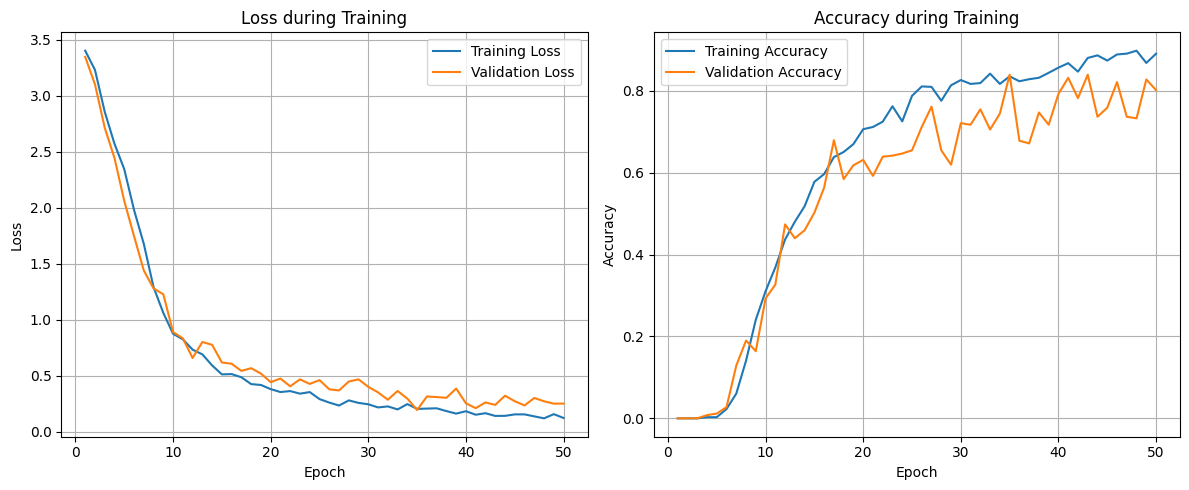

In [24]:
from matplotlib import pyplot as plt

## [ TODO ]
# 1) Plot the loss of the model during training for both training set and validation set.
#    (Hint: for history list of dicts, training loss is `history[epoch]["loss_train"]` and `history[epoch]["loss_vali"]`)
# 2) Plot the accuracy of the model during training for both training set and validation set.
#    (Hint: for history list of dicts, training accuracy is `history[epoch]["acc_train"]` and `history[epoch]["acc_vali"]`)
#    (Note: plot all curves for the same metric on the same graph for comparison)

epochs = [h["epoch"] for h in history_basic]
loss_train = [h["loss_train"] for h in history_basic]
loss_vali = [h["loss_vali"] for h in history_basic]
acc_train = [h["acc_train"] for h in history_basic]
acc_vali = [h["acc_vali"] for h in history_basic]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(epochs, loss_train, label="Training Loss")
plt.plot(epochs, loss_vali, label="Validation Loss")
plt.title("Loss during Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.plot(epochs, acc_train, label="Training Accuracy")
plt.plot(epochs, acc_vali, label="Validation Accuracy")
plt.title("Accuracy during Training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Next, we evaluate our model end-to-end on the test set. Like training and validation set, we transform test set CAPTCHA images through data augmentation. We then predict the characters for these images and compare the predictions with ground truth. Similar to lab 3, we compute the accuracy of our model and show samples of correct and incorrect predictions:

In [28]:
from hw2_util import group_every
def evaluate_model(model, le, dataset_eval, batch_size=32, n_epochs=5, n_display_samples=10, device=None):
    # Detect device from model parameters if not provided
    device = device or next(iter(model.parameters())).device

    ## [ TODO ]
    # Create evaluation data loader from `dataset_eval`
    # (Note: set the batch size)
    loader_eval = DataLoader(dataset_eval, batch_size=batch_size)

    # Number of test samples and correct predictions
    n_test = n_correct = 0
    # Correct and incorrect samples
    correct_samples = []
    incorrect_samples = []

    # Put model in validation mode
    model.eval()

    for i in range(n_epochs):
        # In every epoch, do training first ...
        print(f"Starting evaluation epoch {i+1}/{n_epochs} ...")
        for images_batch, texts_batch in tqdm(loader_eval):
            # Make a copy of images batch on target PyTorch device, while keeping original batch on CPU
            images_batch_device = images_batch.to(device)

            ## [ TODO ]
            # 1) Predict characters with neural network model
            pred_logits = model(images_batch_device)
            # 2) Flatten and move predictions to CPU
            pred_class_indices = pred_logits.argmax(-1)
            pred_class_indices = pred_class_indices.cpu()
            # 3) Decode predicted class indices back to characters using `LabelEncoder.inverse_transform`
            flat_indices = torch.flatten(pred_class_indices)
            decoded_chars = le.inverse_transform(list(flat_indices))
            # 4) Group every 4 characters together to form predicted CAPTCHAs
            #    (Hint: `hw2_util.group_every` can help with grouping)
            predicted_texts = [
                      "".join(group)
                      for group in group_every(decoded_chars, n_elem=4)
                  ]
            # 5) For each CAPTCHA, its prediction and actual text:
            #    - Update number of correct predictions
            #    - Collect `n_display_samples` correct samples of tuple (image, prediction) for review
            #    - Collect `n_display_samples` incorrect samples of tuple (image, prediction, actual) for review
            #      (Caution: DO NOT print ALL correct / incorrect images; this is slow and the output will be messy!)
            for img, pred, actual in zip(images_batch, predicted_texts, texts_batch):
              n_test += 1

              if pred == actual:
                  n_correct += 1
                  if len(correct_samples) < n_display_samples:
                      correct_samples.append((img.squeeze(0), pred))
              else:
                  if len(incorrect_samples) < n_display_samples:
                      incorrect_samples.append((img.squeeze(0), pred, actual))
        # Report loss and metrics
        print(f"Ending evaluation of epoch {i+1}/{n_epochs} ...")

    # Put model back in training mode
    model.train()

    # Show statistics
    print()
    print("# of test CAPTCHAs:", n_test)
    print("# correctly recognized:", n_correct)
    print("Accuracy:", n_correct/n_test, "\n")

    assert len(correct_samples)<=n_display_samples, \
        f"you should only display {n_display_samples} correct samples as examples!"
    assert len(incorrect_samples)<=n_display_samples, \
        f"you should only display {n_display_samples} incorrect samples as examples!"

    # Show all correct predictions
    hw2_util.print_images(
        hw2_util.unzip(correct_samples)[0],
        texts=[f"Correct: {actual}" for _, actual in correct_samples],
        n_rows=2
    )

    # Show all incorrect predictions
    hw2_util.print_images(
        hw2_util.unzip(incorrect_samples)[0],
        texts=[
            f"Prediction: {pred}\nActual: {actual}" \
            for _, pred, actual in incorrect_samples
        ],
        n_rows=2,
        fig_size=(20, 6),
        text_center=(0.5, -0.25)
    )

Now we run the evaluation process on the basic model:

Starting evaluation epoch 1/5 ...


100%|██████████| 8/8 [00:00<00:00, 30.94it/s]


Ending evaluation of epoch 1/5 ...
Starting evaluation epoch 2/5 ...


100%|██████████| 8/8 [00:00<00:00, 29.98it/s]


Ending evaluation of epoch 2/5 ...
Starting evaluation epoch 3/5 ...


100%|██████████| 8/8 [00:00<00:00, 27.21it/s]


Ending evaluation of epoch 3/5 ...
Starting evaluation epoch 4/5 ...


100%|██████████| 8/8 [00:00<00:00, 30.23it/s]


Ending evaluation of epoch 4/5 ...
Starting evaluation epoch 5/5 ...


100%|██████████| 8/8 [00:00<00:00, 29.59it/s]


Ending evaluation of epoch 5/5 ...

# of test CAPTCHAs: 1140
# correctly recognized: 942
Accuracy: 0.8263157894736842 

Figure(2000x500)
Figure(2000x600)


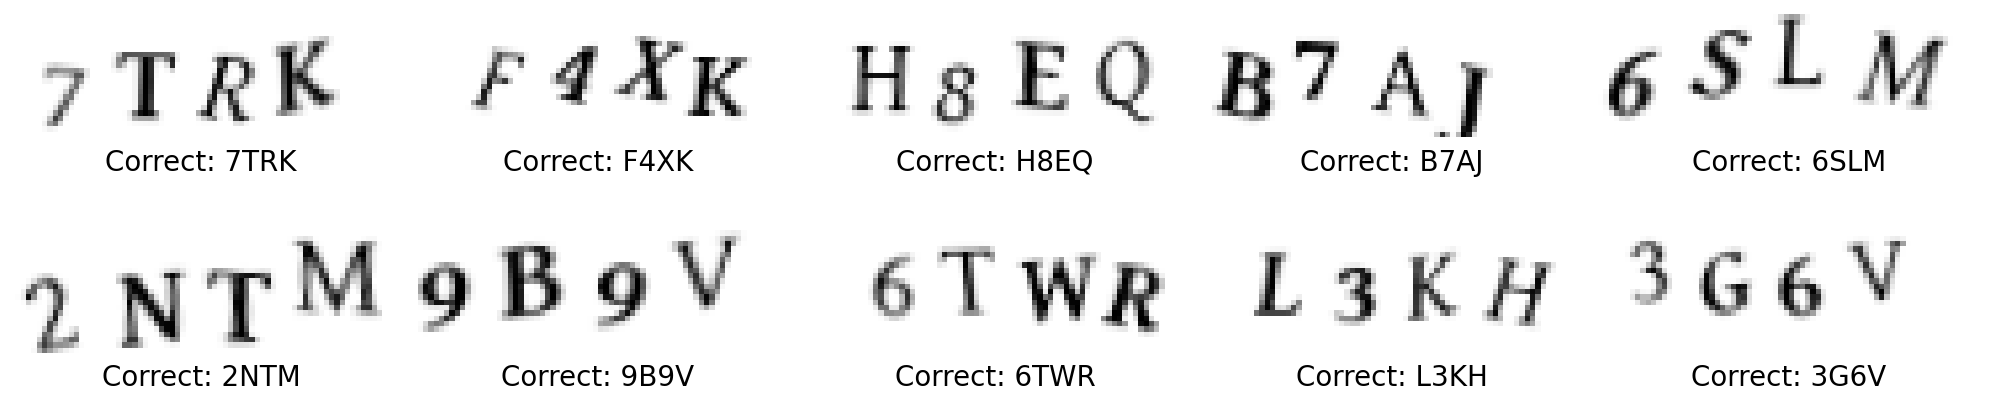

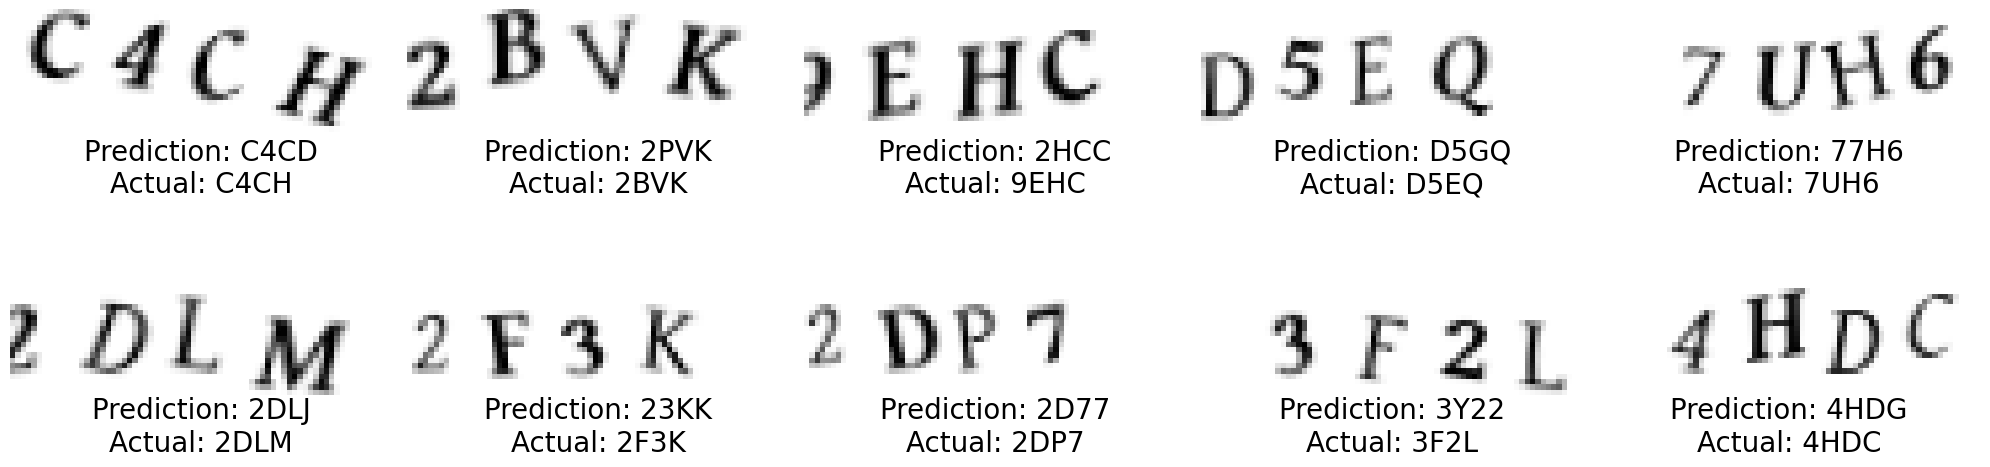

In [29]:
# Build evaluation dataset
dataset_eval = CAPTCHADataset(captcha_images_test, captcha_texts_test, captcha_transform)

# Evaluate the basic model
evaluate_model(model_basic, le, dataset_eval)

## Questions

1. What is the purpose and benefits of data augmentation?


Data augmentation increases the diversity of the training dataset by applying label-preserving transformations such as rotation, translation, scaling, or noise. Its main purpose is to improve generalization and reduce overfitting by teaching the model invariance to small variations in input data.



2. What is the purpose of 1\*1 convolution kernel?
   

A 1×1 convolution is used to perform a linear transformation across the channel dimension at each spatial location. It allows channel reduction or expansion without affecting spatial resolution.



3. What is the purpose of dropout? Does it work on improving the convergence of training or on generalization? Give some reasons to support your idea.

Dropout is a regularization technique that randomly deactivates neurons during training to prevent co-adaptation and reduce overfitting. It primarily improves generalization rather than convergence. While dropout may slow convergence due to added stochasticity, it helps the model learn more robust and distributed feature representations, leading to better performance on unseen data.

4. What is the purpose of batch normalization? Does it work on improving the convergence of training or on generalization? Give some reasons to support your idea.

Batch normalization normalizes layer activations within each mini-batch to have zero mean and unit variance, followed by learnable scaling and shifting. Its primary purpose is to improve convergence by stabilizing activation distributions during training. This allows for higher learning rates, reduces gradient instability, and accelerates optimization. While it may provide slight regularization due to batch noise, its main benefit is faster and more stable training rather than improved generalization.

## Improvements (Optional; Not Graded)

Like homework 1, **you can optionally choose to work on two improvements to the neural network model**, and see if these modifications help with the accuracy. Please note that we won't grade your solutions for these questions, but we may give you feedbacks should you choose to complete them. We also encourage you to **reuse previous code and functions** as much as possible, and avoid repeating identicial code from previous part of this homework.

***

   Neural network models are susceptible to over-fitting problems due to their huge amount of free parameters. When neural network model overfits, it performs extremely well on the training set, but can easily fail when new samples are added. There are three possible approaches to mitigate the over-fitting issue:

  * Adding regularization (L1 and/or L2) to parameters of each linear or convolution layer.
  * Adding dropout layers (`torch.nn.Dropout`) to the model.
  * Adding batch normalization layers (`torch.nn.BatchNorm2d`) to the model.
  
Try one or a few of these approaches and compare their performance with the original model. Complete the following tasks by adding code and text cells  above and compare their performance with the original model. Complete the following tasks by adding code and text cells below:
  
  * Specify your choice of approaches and the details for each approach:
    - For regularization, this is the type of regularization and regularization factor for each convolution and linear layer.
    - For dropout layers, specify the number, position and dropout rate of all dropout layers.
    - For batch normalization layers, specify the number and position of all batch normalization layers.
  * Plot the loss and accuracy for both training and validation set. Think about what curves to put on the same plot.
    - One idea is to put the same metric of all four models (basic model and three improvement models) for the same set (e.g. training set) on the same plot. In this case, you will get four plots in the end.
    - You don't need to include plots as images in the notebook. Instead, just provide the code that can plot these curves.
  * Finally, report the accuracy of all three improvement models on the test set.

## Submission

When you’re done, push this completed notebook (including all code and discussion answers) to your GitHub repo, then submit the repo link on the Canvas submission page.


## References

1. PyTorch API reference: https://pytorch.org/docs/stable/index.html
2. PyTorch Neural Network Modules: https://pytorch.org/docs/stable/nn.html
3. Over-fitting: https://en.wikipedia.org/wiki/Overfitting
4. Residual neural network: https://en.wikipedia.org/wiki/Residual_neural_network
5. Residual blocks - Building blocks of ResNet: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec